# Initialization


In [9]:
import swifter
%cd /home/sitnarf/projects/cardiovascular-risk-app/backend


from notebooks.heart_transplant.dependencies.heart_transplant_data import get_reduced_binary_dataset_cached, \
    get_binary_dataset_cached, keep_only_heart, remove_last_year, reduce_dataset

from notebooks.heart_transplant.dependencies.heart_transplant_functions import filter_out_unused_features, \
    reverse_log_transform_dataset
from notebooks.heart_transplant.dependencies.heart_transplant_metadata import heart_transplant_metadata

from toolz import get

import itertools
import os
from pathlib import Path
from visualisation import display_number

for folder in itertools.chain([Path.cwd()], Path.cwd().parents):
    if (folder / 'Pipfile').exists():
        os.chdir(folder)
        break

from matplotlib import pyplot as plt

%load_ext autoreload
%autoreload 2
%load_ext autotime
%config InlineBackend.figure_format = 'retina'

plt.style.use('dark_background')

/home/sitnarf/projects/cardiovascular-risk-app/backend
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 5.48 ms (started: 2021-03-04 23:22:00 +00:00)


In [10]:
X_365, y_365, dataset_raw = get_reduced_binary_dataset_cached()

X_365_full, y_365_full, _ = get_binary_dataset_cached()

X_90, y_90, _ = get_reduced_binary_dataset_cached(survival_days=90)

time: 3.65 s (started: 2021-03-04 23:22:00 +00:00)


## Exploratory analysis

### Total rows (dataset_raw)

In [11]:
display_number(len(dataset_raw))

time: 1.74 ms (started: 2021-03-04 23:22:04 +00:00)


### Total rows (transplantation has occurred)

In [12]:
X_total = dataset_raw[~dataset_raw['death'].isna()]

display_number(len(X_total))

time: 86.8 ms (started: 2021-03-04 23:22:04 +00:00)


### Total rows (only heart transplantation)

In [13]:
X_only_heart = keep_only_heart(X_total)
display_number(len(X_only_heart))

time: 68.2 ms (started: 2021-03-04 23:22:04 +00:00)


### Total rows (year 2017 removed)

In [14]:
X_only_heart = remove_last_year(X_only_heart)
display_number(len(X_only_heart))


time: 80.3 ms (started: 2021-03-04 23:22:04 +00:00)


### Total rows (only with > 80 non-missing variables kept)

In [15]:
from functional import pipe
from functools import partial

X_reduced = pipe(
    X_only_heart,
    partial(filter_out_unused_features, metadata=heart_transplant_metadata),
    partial(reduce_dataset, y=y_365),
    partial(get, 0),
)

display_number(len(X_reduced))

time: 3.63 s (started: 2021-03-04 23:22:04 +00:00)


### Total rows with 365 days survival defined

In [16]:
display_number(len(X_365))

time: 1.96 ms (started: 2021-03-04 23:22:08 +00:00)


### Total rows with 90 days survival defined

In [17]:
display_number(len(X_90))

time: 1.9 ms (started: 2021-03-04 23:22:08 +00:00)


### Number of available variable per row histogram (dataset_raw)

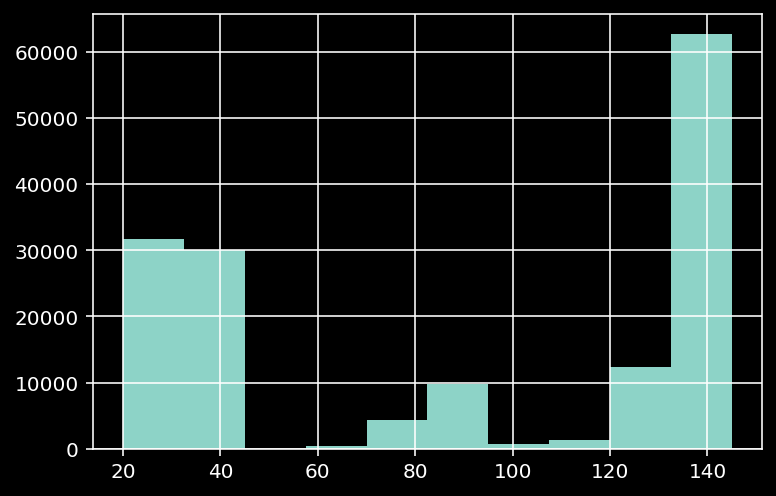

time: 3.05 s (started: 2021-03-04 23:22:08 +00:00)


In [18]:
dataset_raw.swifter.apply(lambda x: x.count(), axis=1).hist();

### Number of available variables per row histogram (final all age groups)

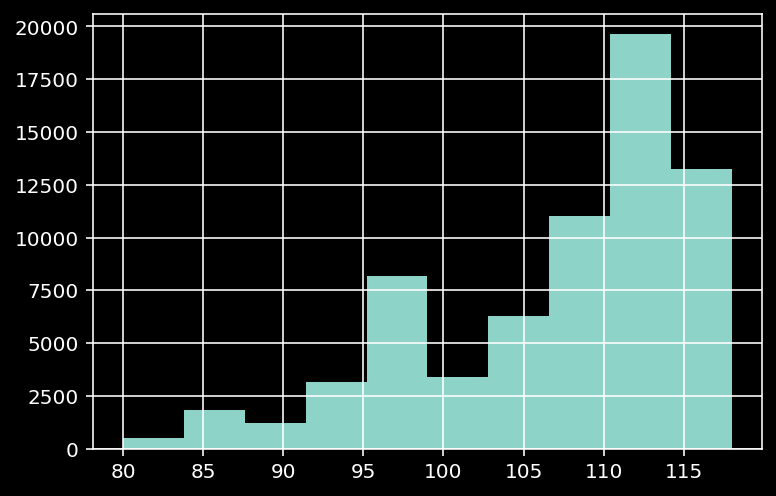

time: 2.27 s (started: 2021-03-04 23:22:11 +00:00)


In [19]:
X_365.swifter.apply(lambda x: x.count(), axis=1).hist();

## Class balance

### 365 days survival

In [20]:
y_365.value_counts()

0    59967
1     8495
dtype: int64

time: 4.57 ms (started: 2021-03-04 23:22:13 +00:00)


### 90 days survival

In [21]:
y_90.value_counts()

0    65796
1     5571
dtype: int64

time: 3.38 ms (started: 2021-03-04 23:22:13 +00:00)


## Features

> left: input
>
> ⬇
>
> center: preprocessed / omitted
>
> ⬇
>
> right: log / omitted

In [ ]:
from notebooks.heart_transplant.dependencies.heart_transplant_metadata import heart_transplant_metadata as metadata
from matplotlib import pyplot

X_365_reverse_log = reverse_log_transform_dataset(X_365)

for index, (feature_name, series) in enumerate(dataset_raw.items()):

    fig, ax = pyplot.subplots(1, 3, figsize=(5, 2))

    try:
        series.sample(frac=0.1).hist(grid=False, ax=ax[0])
    except Exception as e:
        print(e)

    log_feature_name = f'log_{feature_name}'

    try:
        X_365_reverse_log[feature_name]
    except KeyError:
        ax[1].axis("off")
    else:
        X_365_reverse_log[feature_name].loc[X_365.index].sample(frac=0.1).hist(
            grid=False, ax=ax[1]
        )

    try:
        X_365[log_feature_name]
    except KeyError:
        ax[2].axis("off")
    else:
        X_365[log_feature_name].loc[X_365.index].sample(frac=0.1).hist(
            grid=False, ax=ax[2]
        )

    metadata_item = metadata.get(feature_name)

    if log_feature_name in X_365:
        target_feature_name = log_feature_name
    else:
        target_feature_name = feature_name

    try:
        display_name = f'{metadata_item["name_long"]} ({target_feature_name})'
    except (KeyError, TypeError):
        display_name = f'{target_feature_name}'

    print(f'{index + 1}. {display_name}')
    fig.tight_layout()
    display(fig)
    pyplot.close()

print()

## Death-year relationship


In [ ]:
def set_x_ticks():
    plt.xticks([*range(int(dataset_raw['tx_year'].min()), int(dataset_raw['tx_year'].max()), 3),
                int(dataset_raw['tx_year'].max())])


pyplot.title('Total deaths per year')
dataset_raw['death'].groupby(dataset_raw['tx_year']).sum().plot()
pyplot.setp(pyplot.gca().get_xticklabels(), rotation=30, horizontalalignment='right')
set_x_ticks()
pyplot.show()

pyplot.title('Total transplant per year')
dataset_raw['death'].groupby(dataset_raw['tx_year']).count().plot()
pyplot.setp(pyplot.gca().get_xticklabels(), rotation=30, horizontalalignment='right')
plt.xticks([*range(int(dataset_raw['tx_year'].min()), int(dataset_raw['tx_year'].max()), 3),
            int(dataset_raw['tx_year'].max())])

pyplot.show()



In [ ]:
import matplotlib as mpl
from matplotlib import pyplot as plt

grouped = dataset_raw['death'].groupby(dataset_raw['tx_year'])
pyplot.title('Percentage of mortality at any moment')
(grouped.sum() / grouped.count() * 100).plot()

plt.setp(pyplot.gca().get_xticklabels(), rotation=30, horizontalalignment='right')
plt.xticks([*range(int(dataset_raw['tx_year'].min()), int(dataset_raw['tx_year'].max()), 3),
            int(dataset_raw['tx_year'].max())])
plt.gca().yaxis.set_major_formatter(mpl.ticker.PercentFormatter())

pyplot.show()

grouped = y_365.groupby(dataset_raw['tx_year'])
pyplot.title('Percentage of 1-year mortality')
(grouped.sum() / grouped.count() * 100).plot()

plt.setp(pyplot.gca().get_xticklabels(), rotation=30, horizontalalignment='right')
plt.xticks([*range(int(dataset_raw['tx_year'].min()), int(dataset_raw['tx_year'].max()), 3),
            int(dataset_raw['tx_year'].max())])
plt.gca().yaxis.set_major_formatter(mpl.ticker.PercentFormatter())

pyplot.show()